# Model and simulate a bank branch

## The goal

Decrease the number of reneging customers.


## Install ```SimPy```
```
pip install -U simpy
```

## Develop a model

### Step 1: One customer arriving at a fixed time

In [4]:
import simpy

# Model components
#-------------------------------------- 
def customer(env, name, time_in_bank):                          
    print('t: %1.2f \t%s \tHere I am' % (env.now, name))
    yield env.timeout(time_in_bank)
    print('t: %1.2f \t%s \tI must leave' % (env.now, name)) 

# Experiment parameters
#--------------------------------------
max_time = 100.0     # minutes                            
time_in_bank = 10.0   # minutes

# Simulation/Experiment
#--------------------------------------
env = simpy.Environment(initial_time=5.0)
proc = env.process(customer(env, 'Kalle', time_in_bank))
# Start processes
env.run(until=max_time)

t: 5.00 	Kalle 	Here I am
t: 15.00 	Kalle 	I must leave


### Step 2: One customer arriving at a random time

In [7]:
import simpy
import random


# Model components
#-------------------------------------- 
def customer(env,name, time_in_bank):                          
    print('t: %7.3f %s \tHere I am' % (env.now, name))
    yield env.timeout(time_in_bank)
    print('t: %7.3f %s \tI must leave' % (env.now, name))  

# Experiment parameters
#--------------------------------------
max_time = 100.0     # minutes                            
time_in_bank = 10.0   # minutes

# Simulation/Experiment
#--------------------------------------
random.seed(5)    
t = random.expovariate(1.0/5.0)                               
env = simpy.Environment(initial_time=t)
proc = env.process(customer(env, 'Kalle', time_in_bank))
# Start processes
env.run(until=max_time)

t:   4.876 Kalle 	Here I am
t:  14.876 Kalle 	I must leave


#### Detour -- ```random.expovariate()?```
Random values from some kind of distribution.

##### Question
How does this distribution look?
Answer: Plot the distribution

(0.0, 1653.75)

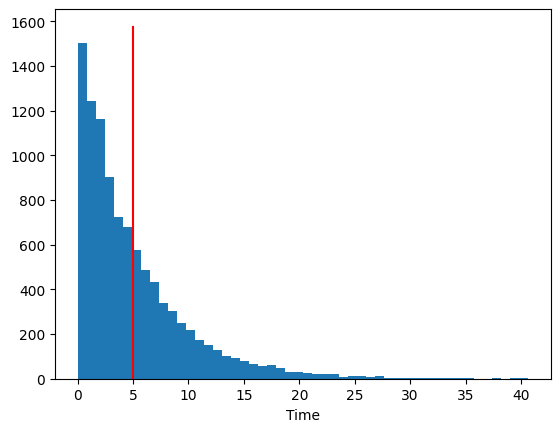

In [34]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

# Exponential distribution. lambd is 1.0 divided by the desired mean.

desired_mean = 5.0

t = np.empty(10000)
for i in range(t.shape[0]):
    t[i] = random.expovariate(1.0 / desired_mean) 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(t, 50)
ax.set_xlabel('Time')
ylim = ax.get_ylim()
ax.plot([desired_mean, desired_mean], ylim, 'r')
ax.set_ylim()

### Step 3: Multiple randomly arriving customers

The times between customer arrivals are distributed as exponential random variates.

In [ ]:
import simpy
import random


# Model components
#-------------------------------------- 
def source(env, number, interval, time_in_bank):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, time_in_bank=time_in_bank)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)
        
def customer(env,name, time_in_bank):                          
    print('t: %7.3f %s \tHere I am' % (env.now, name))
    yield env.timeout(time_in_bank)
    print('t: %7.3f %s \tI must leave' % (env.now, name))  

# Experiment parameters
#--------------------------------------
time_in_bank = 12.0
max_time = 400.0     # minutes                              
tot_customers = 5    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min


# Simulation/Experiment
#--------------------------------------
print('Bank renege')
random.seed(6)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, tot_customers, customer_interval, time_in_bank))
env.run()


**This bank has customers, but something is missing. What?**

### Step 4: a service counter
The customers are going to require service from the bank clerk.

This example models a bank counter and customers arriving *t* random times. Each customer has a certain patience. It waits to get to the counter until she’s at the end of her tether and then leaves. If she gets to the counter, she uses it for a while before releasing it.

We extend the model to include a service counter which will be modelled as an object of SimPy’s ```Resource``` class with a single resource unit. The actions of a ```Resource``` are simple: a customer requests a unit of the resource (i.e. a clerk). If it is free the customer gets service (and removes the unit). If it is not free clerk the customer joins the queue (managed by the resource object) until it is their turn to be served.


#### One service counter
A counter with a random service time and customers who renege.

In [ ]:
import random
import simpy


# Model components
#-------------------------------------- 
def source(env, number, interval, counter, time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.2f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.2f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_at_counter)
            yield env.timeout(tib)
            print('%7.2f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.2f %s: RENEGED after %6.3f' % (env.now, name, wait))

            
# Experiment parameters
#-------------------------------------- 
time_at_counter = 25.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 5    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 1.    # Min. customer patience
max_patience = 3.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
print('Bank renege')
random.seed(42)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, tot_customers, customer_interval, counter, time_at_counter, min_patience, max_patience))
env.run()

#### Multiple service counters

Multiple service counters with a random service time and customers who renege.
**But, how will customers queue?**
* All in one queue?
* Multiple parallel queues?
* Or, completely anarchistically, switch between multiple parallel queues?

##### Two counters with one shared queue

In [15]:
import random
import simpy


# Model components
#-------------------------------------- 
def source(env, number, interval, counter, time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.2f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.2f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_at_counter)
            yield env.timeout(tib)
            print('%7.2f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.2f %s: RENEGED after %6.3f' % (env.now, name, wait))

            
# Experiment parameters
#-------------------------------------- 
time_at_counter = 25.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 5    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 1.    # Min. customer patience
max_patience = 3.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
print('Bank renege')
random.seed(42)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=2)
env.process(source(env, tot_customers, customer_interval, counter, time_at_counter, min_patience, max_patience))
env.run()

Bank renege
   0.00 Customer00: Here I am
   0.00 Customer00: Waited  0.000
   8.04 Customer00: Finished
  10.20 Customer01: Here I am
  10.20 Customer01: Waited  0.000
  12.73 Customer02: Here I am
  12.73 Customer02: Waited  0.000
  26.43 Customer02: Finished
  35.00 Customer03: Here I am
  35.00 Customer03: Waited  0.000
  35.30 Customer04: Here I am
  36.70 Customer04: RENEGED after  1.398
  38.43 Customer01: Finished
  52.60 Customer03: Finished


##### Several counters with individual queues

Each customer choses to join the shortest queue.

###### Question
**How can we model this situation?**

In [18]:
import random
import simpy


# Model components
#-------------------------------------- 
def source(env, number, interval, counters, time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counters, time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counters, time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    
    # get queue lengths
    q_lens = [c.count for c in counters]
    print('%7.2f %s: Here I am, queue lengths: %s' % (arrive, name, q_lens))
    
    # chose the shortest queue
    choice = q_lens.index(min(q_lens))

    with counters[choice].request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.2f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_at_counter)
            yield env.timeout(tib)
            print('%7.2f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.2f %s: RENEGED after %6.3f' % (env.now, name, wait))
            
            
# Experiment parameters
#-------------------------------------- 
time_at_counter = 25.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 5    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 1.    # Min. customer patience
max_patience = 3.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
print('Bank renege')
random.seed(42)
env = simpy.Environment()

# Start processes and run
counters = [simpy.Resource(env, capacity=1), simpy.Resource(env, capacity=1)]
env.process(source(env, tot_customers, customer_interval, counters, time_at_counter, min_patience, max_patience))
env.run()

Bank renege
   0.00 Customer00: Here I am, queue lengths: [0, 0]
   0.00 Customer00: Waited  0.000
   8.04 Customer00: Finished
  10.20 Customer01: Here I am, queue lengths: [0, 0]
  10.20 Customer01: Waited  0.000
  12.73 Customer02: Here I am, queue lengths: [1, 0]
  12.73 Customer02: Waited  0.000
  26.43 Customer02: Finished
  35.00 Customer03: Here I am, queue lengths: [1, 0]
  35.00 Customer03: Waited  0.000
  35.30 Customer04: Here I am, queue lengths: [1, 1]
  36.70 Customer04: RENEGED after  1.398
  38.43 Customer01: Finished
  52.60 Customer03: Finished


**End of model building**

We got ourselves a model.

However, something is missing... Can we really use this for decision making?

## Sample from our model

We need to get some data we can generalize from. That is, we need to gather data from longer and multiple runs.

### Questions
* How to sample?
* How to collect data?

In [21]:
import random
import simpy
import numpy as np


# Model components
#-------------------------------------- 
data = {'wait': [], 'reneg': []}

def source(env, number, interval, counters, time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counters, time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counters, time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    
    # get queue lengths
    q_lens = [c.count for c in counters]    
    # chose the shortest queue
    choice = q_lens.index(min(q_lens))

    with counters[choice].request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive
        data['wait'].append(wait)  # data is declared above, in the global scope

        if req in results:
            tib = random.expovariate(1.0 / time_at_counter)
            data['reneg'].append(False)
            yield env.timeout(tib)
        else:
            # We reneged
            data['reneg'].append(True)
            
            
# Experiment parameters
#-------------------------------------- 
time_at_counter = 25.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 10000    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 1.    # Min. customer patience
max_patience = 3.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
random.seed(42)
env = simpy.Environment()

# Start processes and run
counters = [simpy.Resource(env, capacity=1), simpy.Resource(env, capacity=1)]
env.process(source(env, tot_customers, customer_interval, counters, time_at_counter, min_patience, max_patience))
env.run()

reneg = np.array(data['reneg'])
wait_times = np.array(data['wait'])
print('Average wait time for %d customers was %1.3f min and %1.1f%% reneged' % (tot_customers, wait_times.mean(), 100 * reneg.sum()/tot_customers))

Average wait time for 10000 customers was 0.949 min and 45.9% reneged


## Decisions, decisions...

### We got a problem

**Too many customers reneg, but we cannot employ more clerks. What should we do?**

Maybe customers get tired legs.

Get a sofa!!


#### Question
**How would we model the effects of a sofa?**

Answer: increase patience
    

In [24]:
import random
import simpy
import numpy as np


# Model components
#-------------------------------------- 
data = {'wait': [], 'reneg': [], 'tib': []}

def source(env, number, interval, counters, time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counters, time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counters, time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    
    # get queue lengths
    q_lens = [c.count for c in counters]    
    # chose the shortest queue
    choice = q_lens.index(min(q_lens))

    with counters[choice].request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive
        data['wait'].append(wait)  # data is declared above, in the global scope

        if req in results:
            tib = random.expovariate(1.0 / time_at_counter)
            data['reneg'].append(False)
            data['tib'].append(tib)
            yield env.timeout(tib)
        else:
            # We reneged
            data['reneg'].append(True)
            data['tib'].append(-1)
            
            
# Experiment parameters
#-------------------------------------- 
time_at_counter = 25.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 1000    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 5.    # Min. customer patience
max_patience = 30.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
random.seed(42)
env = simpy.Environment()

# Start processes and run
counters = [simpy.Resource(env, capacity=1), simpy.Resource(env, capacity=1)]
env.process(source(env, tot_customers, customer_interval, counters, time_at_counter, min_patience, max_patience))
env.run()

reneg = np.array(data['reneg'])
wait_times = np.array(data['wait'])
print('Average wait time for %d customers was %1.3f min and %1.1f%% reneged' % (tot_customers, wait_times.mean(), 100 * reneg.sum()/tot_customers))

Average wait time for 1000 customers was 8.862 min and 41.2% reneged


**Other improvements?**

How about training the clerks so that they can help the customers faster?

#### Question
**How could we model faster clerks?**

Answer: Decrease average time at counter

In [27]:
import random
import simpy
import numpy as np


# Model components
#-------------------------------------- 
data = {'wait': [], 'reneg': [], 'tib': []}

def source(env, number, interval, counters, ave_time_at_counter, min_patience, max_patience):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counters, ave_time_at_counter, min_patience, max_patience)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counters, ave_time_at_counter, min_patience, max_patience):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    
    # get queue lengths
    q_lens = [c.count for c in counters]    
    # chose the shortest queue
    choice = q_lens.index(min(q_lens))

    with counters[choice].request() as req:
        patience = random.uniform(min_patience, max_patience)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive
        data['wait'].append(wait)  # data is declared above, in the global scope

        if req in results:
            tib = random.expovariate(1.0 / ave_time_at_counter)
            data['reneg'].append(False)
            data['tib'].append(tib)
            yield env.timeout(tib)
        else:
            # We reneged
            data['reneg'].append(True)
            data['tib'].append(-1)
            
            
# Experiment parameters
#-------------------------------------- 
ave_time_at_counter = 15.0  # minutes                              
max_time = 400.0     # minutes                              
tot_customers = 1000    # total number of customers
customer_interval = 10.0  # Generate new customers roughly every x min
min_patience = 1.    # Min. customer patience
max_patience = 3.    # Max. customer patience


# Simulation/Experiment
#--------------------------------------
random.seed(42)
env = simpy.Environment()

# Start processes and run
counters = [simpy.Resource(env, capacity=1), simpy.Resource(env, capacity=1)]
env.process(source(env, tot_customers, customer_interval, counters, ave_time_at_counter, min_patience, max_patience))
env.run()

reneg = np.array(data['reneg'])
wait_times = np.array(data['wait'])
print('Average wait time for %d customers was %1.3f min and %1.1f%% reneged' % (tot_customers, wait_times.mean(), 100 * reneg.sum()/tot_customers))

Average wait time for 1000 customers was 0.573 min and 26.3% reneged


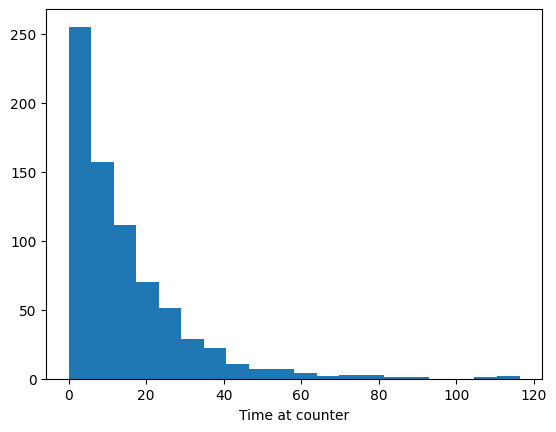

In [29]:
import matplotlib.pyplot as plt
plt.ion()

tib = np.array(data['tib'])
tib = tib[tib > -1]

plt.hist(tib, 20)
plt.xlabel('Time at counter')
plt.show()